# PS07: Outlier analysis

The objective of this session is to practice finding outliers by implementing the Isolation Forest algorithm.

# 0. Preliminaries

## 0.1. Required imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

## 0.2. Dataset

We will use the file `thyroid.csv` that contains data about exams of the thyroid gland of 3,772 patients. In each exam, six attributes *f1*, *f2*, ..., *f6* of each patient are measured. A ground-truth label indicating if the thyroid was finally found to be normal or abnormal is included in the dataset. Further information on this dataset can be found in this [free repository](http://odds.cs.stonybrook.edu/thyroid-disease-dataset/).

In [2]:
df = pd.read_csv('Datasets/thyroid.csv', sep=',')

# Add a patient-id (just a sequence number)
df['id'] = df.index

# Re-order columns
df = df[['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'abnormal']]

# Report
print("Total patients   : %d" % len(df))
print("Normal thyroid   : %d" % len(df[df['abnormal'] == 0.0]))
print("Abnormal thyroid : %d" % len(df[df['abnormal'] == 1.0]))
print("Features         : %s" % df.columns.get_values())

Total patients   : 3772
Normal thyroid   : 3679
Abnormal thyroid : 93
Features         : ['id' 'f1' 'f2' 'f3' 'f4' 'f5' 'f6' 'abnormal']


Print some example data

In [3]:
print(df[df['abnormal'] == 1.0].head(5))
print(df[df['abnormal'] == 0.0].head(5))

      id        f1        f2        f3        f4        f5        f6  abnormal
19    19  0.526882  0.115094  0.086338  0.025701  0.455399  0.014754       1.0
27    27  0.827957  0.047170  0.080645  0.112150  0.305164  0.095082       1.0
105  105  0.774194  0.088679  0.099620  0.116822  0.333333  0.091803       1.0
115  115  0.451613  0.132075  0.042694  0.002103  0.399061  0.001311       1.0
116  116  0.440860  0.058491  0.071157  0.025701  0.469484  0.014754       1.0
   id        f1        f2        f3        f4        f5        f6  abnormal
0   0  0.774194  0.001132  0.137571  0.275701  0.295775  0.236066       0.0
1   1  0.247312  0.000472  0.279886  0.329439  0.535211  0.173770       0.0
2   2  0.494624  0.003585  0.222960  0.233645  0.525822  0.124590       0.0
3   3  0.677419  0.001698  0.156546  0.175234  0.333333  0.136066       0.0
4   4  0.236559  0.000472  0.241935  0.320093  0.333333  0.247541       0.0


Note that identifying outliers in this dataset is possible because outliers are quite different, across many dimensions, from inliers. To show this, we can create all scatter plots of combinations of two dimensions in the data. In these, you can see that feature values for the minority class (represented by the color that appears less), indeed are quite different from feature values for the majority class (represented by the color that appears more).

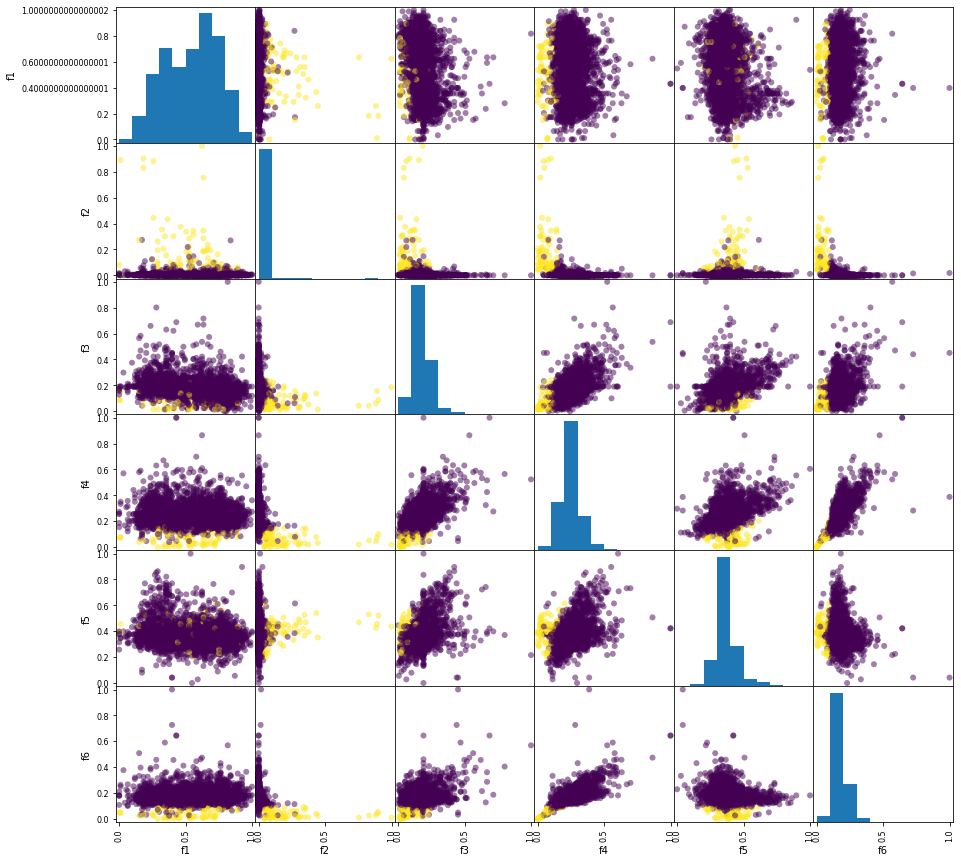

In [4]:
pd.plotting.scatter_matrix(df.drop(columns=['id', 'abnormal']), c=df['abnormal'], figsize=(15, 15), marker='o', alpha=0.5)
plt.show()

# 1. Create isolation tree

## 1.1. Random dimension and random split

[**CODE**] Create a function that returns a random dimension in the dataset. We will ignore some columns, because the random dimension can never be *id* or *abnormal, but instead should be one of the other dimensions 'f1', 'f2', ..., 'f6'. Do not hard-code these dimensions into your function, instead, read df.columns

In [5]:
def pick_random_dimension(df, columns_to_ignore):
    # YOUR CODE HERE
    new_columns = df.columns.drop(columns_to_ignore).tolist()
    return new_columns[random.randint(0,len(new_columns) -1)]

In [6]:
print(pick_random_dimension(df, ["id", "abnormal"]))
print(pick_random_dimension(df, ["id", "abnormal"]))

f5
f5


[**CODE**] Create a function that returns a random split point along a dimension. Do not rely on the fact that, *on this dataset* every dimension takes a value between 0.0 and 1.0. Instead, use `np.min(df[dimension])` and `np.max(df[dimension])`.

In [7]:
def pick_random_split(df, dimension):
    # YOUR CODE HERE
    return(df.sample()[dimension].array[0])

In [8]:
print(pick_random_split(df, "f4"))
print(pick_random_split(df, "f4"))

0.18691588785
0.30607476635499997


## 1.2. Implement split data into two

[**CODE**] Implement a function `split_dataset(df, dimension, split)` that returns two sub-datasets: one with all elements having *dimension <= split*, and another one with all elements having *dimension > split*.

In [9]:
def split_dataset(df, dimension, split):
    # YOUR CODE HERE
    sorted_df = df.sort_values([dimension])
    cut = 0
    for index, row in sorted_df.iterrows():
        if row[dimension] > split:
            break
        cut +=1
        
    left = sorted_df[0:cut].sort_values('id')
    right = sorted_df[cut:].sort_values('id')
    return (left, right)

In [10]:
left, right = split_dataset(df, 'f1', 0.4)
print(left.head(3))
print(right.head(3))

    id        f1        f2        f3        f4        f5        f6  abnormal
1    1  0.247312  0.000472  0.279886  0.329439  0.535211  0.173770       0.0
4    4  0.236559  0.000472  0.241935  0.320093  0.333333  0.247541       0.0
11  11  0.182796  0.000189  0.213472  0.224299  0.309859  0.185246       0.0
   id        f1        f2        f3        f4        f5        f6  abnormal
0   0  0.774194  0.001132  0.137571  0.275701  0.295775  0.236066       0.0
2   2  0.494624  0.003585  0.222960  0.233645  0.525822  0.124590       0.0
3   3  0.677419  0.001698  0.156546  0.175234  0.333333  0.136066       0.0


Test your function. Notice that in the output, all the rows in *left* have *f1 <= 0.4* and all the rows in *right* have *f1 > 0.4*.

In [11]:
left, right = split_dataset(df, 'f1', 0.4)
print(left.head(3))
print(right.head(3))

    id        f1        f2        f3        f4        f5        f6  abnormal
1    1  0.247312  0.000472  0.279886  0.329439  0.535211  0.173770       0.0
4    4  0.236559  0.000472  0.241935  0.320093  0.333333  0.247541       0.0
11  11  0.182796  0.000189  0.213472  0.224299  0.309859  0.185246       0.0
   id        f1        f2        f3        f4        f5        f6  abnormal
0   0  0.774194  0.001132  0.137571  0.275701  0.295775  0.236066       0.0
2   2  0.494624  0.003585  0.222960  0.233645  0.525822  0.124590       0.0
3   3  0.677419  0.001698  0.156546  0.175234  0.333333  0.136066       0.0


## 1.3. Create one isolation tree

An isolation tree will be a dictionary. In this dictionary, having *contents*, indicates an external node of the tree, while having *left* and *right* indicates an internal node of the tree.

[**CODE**] Create a recursive function `isolation_tree(data, columns_to_ignore, min_items)` that:

* If the *data* has *min_items* or less:
    * Return a dictionary `{"contents": data}`
* If the *data* has more than *min_items*
    * Selects a random dimension from the data, ignoring the *columns_to_ignore*
    * Selects a random split point along that dimension
    * Sets `left` to an isolation tree containing points having dimension <= split
    * Sets `right` to an isolation tree containing points having dimension > split
    * Returns a dictionary `{"left": left, "right": right, "dimension": dimension, "split": split}`


In [12]:
def isolation_tree(data, columns_to_ignore, min_items):
    if len(data) <= min_items:
        # YOUR CODE HERE
        return {'contents' : data}
    else:
        # YOUR CODE HERE
        rand_dim = pick_random_dimension(data, columns_to_ignore)
        rand_split = pick_random_split(data, rand_dim)
        left, right = split_dataset(data, rand_dim, rand_split)
        return {'left' : isolation_tree(left, columns_to_ignore, min_items), 'right' : isolation_tree(right, columns_to_ignore, min_items), 'dimension' : rand_dim, 'split' : rand_split}

Test your function creating a shallow tree.

In [13]:
mytree = isolation_tree(df, ['id', 'abnormal'], 300)

You do not need to modify the next function, which is useful to print a tree in ASCII.

In [14]:
class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("L", level+1)
        if self.right:
            ret += self.right.__str__("R", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['abnormal'] == 0.0])
        abnormal_count = len(data[data['abnormal'] == 1.0])
        description = "%d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = tree['dimension'] + '<=' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

Print your tree using this function. Given that the tree is created by a randomized process, your tree will look different from this one.

In [15]:
print(tree_to_nodes(mytree))

:'f4<=0.25'
-L:'f1<=0.48'
--L:'f4<=0.17'
---L:'135 normal + 37 abnormal'
---R:'f4<=0.23'
----L:'f1<=0.19'
-----L:'50 normal + 0 abnormal'
-----R:'f1<=0.28'
------L:'91 normal + 0 abnormal'
------R:'279 normal + 0 abnormal'
----R:'155 normal + 0 abnormal'
--R:'f6<=0.21'
---L:'f3<=0.20'
----L:'f3<=0.09'
-----L:'133 normal + 38 abnormal'
-----R:'f2<=0.00'
------L:'f6<=0.16'
-------L:'151 normal + 0 abnormal'
-------R:'163 normal + 0 abnormal'
------R:'f2<=0.00'
-------L:'217 normal + 0 abnormal'
-------R:'f3<=0.11'
--------L:'29 normal + 3 abnormal'
--------R:'279 normal + 13 abnormal'
----R:'157 normal + 2 abnormal'
---R:'43 normal + 0 abnormal'
-R:'f6<=0.22'
--L:'f5<=0.36'
---L:'178 normal + 0 abnormal'
---R:'f3<=0.22'
----L:'f2<=0.01'
-----L:'f6<=0.18'
------L:'f1<=0.76'
-------L:'f5<=0.68'
--------L:'f6<=0.18'
---------L:'141 normal + 0 abnormal'
---------R:'241 normal + 0 abnormal'
--------R:'4 normal + 0 abnormal'
-------R:'39 normal + 0 abnormal'
------R:'283 normal + 0 abnormal'
-

# 2. Create isolation forests and find depth of items

An isolation forest will be a an array of isolation trees.

## 2.1. Create an isolation forest

[**CODE**] Write a function `isolation_forest(df, columns_to_ignore, min_items, num_trees)` that creates an array of *num_trees* isolation trees.

In [16]:
def isolation_forest(df, columns_to_ignore, min_items, num_trees):
    # YOUR CODE HERE
    forest = []
    for i in range(num_trees):
        print('Adding tree', i+1, 'of', num_trees, 'to the forest.')
        forest.append(isolation_tree(df, columns_to_ignore, min_items))
    return forest

In [17]:
min_items = 10
num_trees = 20
myforest = isolation_forest(df, ['id', 'abnormal'], min_items, num_trees)

print("The forest has %d trees" % len(myforest))

Adding tree 1 of 20 to the forest.
Adding tree 2 of 20 to the forest.
Adding tree 3 of 20 to the forest.
Adding tree 4 of 20 to the forest.
Adding tree 5 of 20 to the forest.
Adding tree 6 of 20 to the forest.
Adding tree 7 of 20 to the forest.
Adding tree 8 of 20 to the forest.
Adding tree 9 of 20 to the forest.
Adding tree 10 of 20 to the forest.
Adding tree 11 of 20 to the forest.
Adding tree 12 of 20 to the forest.
Adding tree 13 of 20 to the forest.
Adding tree 14 of 20 to the forest.
Adding tree 15 of 20 to the forest.
Adding tree 16 of 20 to the forest.
Adding tree 17 of 20 to the forest.
Adding tree 18 of 20 to the forest.
Adding tree 19 of 20 to the forest.
Adding tree 20 of 20 to the forest.
The forest has 20 trees


## 2.2. Find average depth of an item

This is a complicated function so we provide it. No need to implement them yourselves.

In [18]:
def find_element_depth_aux(tree, column_name, column_value, depth):
    if 'contents' in tree:
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your definition")
            return None
        else:
            return depth
    else:
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

Test it by running it 30 times.

In [19]:
for i in range(30):
    random_id = random.randint(0, len(df.index))
    abnormal = float(df[df['id'] == random_id]['abnormal'])
    state = "abnormal" if abnormal == 1.0 else "normal"
    print("Element id=%d (%s) is at depth %d" % (random_id, state, find_element_depth(mytree, "id", random_id)))

Element id=317 (normal) is at depth 7
Element id=351 (normal) is at depth 4
Element id=1651 (normal) is at depth 6
Element id=845 (normal) is at depth 7
Element id=2991 (normal) is at depth 6
Element id=92 (normal) is at depth 3
Element id=2952 (normal) is at depth 6
Element id=2894 (normal) is at depth 9
Element id=432 (normal) is at depth 4
Element id=2204 (normal) is at depth 6
Element id=3550 (abnormal) is at depth 5
Element id=2932 (normal) is at depth 7
Element id=2634 (normal) is at depth 5
Element id=628 (normal) is at depth 3
Element id=712 (normal) is at depth 4
Element id=1991 (normal) is at depth 9
Element id=2886 (normal) is at depth 5
Element id=2939 (normal) is at depth 4
Element id=2339 (abnormal) is at depth 8
Element id=209 (normal) is at depth 6
Element id=2824 (normal) is at depth 4
Element id=225 (normal) is at depth 6
Element id=3465 (normal) is at depth 9
Element id=581 (normal) is at depth 4
Element id=700 (normal) is at depth 7
Element id=2741 (normal) is at de

[**CODE**] Find the average depth of an element

In [20]:
def find_average_depth(forest, column_name, column_value):
    # YOUR CODE HERE
    mean = 0
    for tree in forest:
        mean += find_element_depth(tree, column_name, column_value)
    mean = mean/len(forest)
    return mean

Test this function with some random elements.

In [21]:
for i in range(10):
    random_id = random.randint(0, len(df.index))
    abnormal = float(df[df['id'] == random_id]['abnormal'])
    state = 'abnormal' if abnormal == 1.0 else 'normal'
    print("Element id=%d (%s) is at average depth %.2f" % (random_id, state, find_average_depth(myforest, 'id', random_id)))

Element id=2141 (normal) is at average depth 14.20
Element id=1391 (normal) is at average depth 10.80
Element id=492 (normal) is at average depth 10.15
Element id=1807 (normal) is at average depth 12.00
Element id=903 (normal) is at average depth 12.75
Element id=1149 (normal) is at average depth 11.50
Element id=1586 (normal) is at average depth 12.50
Element id=3086 (normal) is at average depth 11.85
Element id=3195 (normal) is at average depth 15.35
Element id=1978 (normal) is at average depth 15.15


[**REPORT**] Indicate in your report how could you make this more efficiently if you wanted to determine the average depth of all elements.

[**CODE**] **Optionally for additional +2 points**, implement a faster method for finding_average_depths, indicating in your report that you implemented a faster method. Then, in the next section instead of sampling take all the elements in the dataset, i.e., remove `.sample(50)`.

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

The following code samples some abnormal and normal points.

In [22]:
abnormal_point_ids = list(df[df['abnormal'] == 1.0]['id'].sample(50))
normal_point_ids = list(df[df['abnormal'] == 0.0]['id'].sample(50))

print("Normal point ids   : %s" % normal_point_ids)
print("Abnormal point ids : %s" % abnormal_point_ids)

Normal point ids   : [576, 2878, 1138, 3609, 2246, 1562, 3513, 1921, 1587, 1919, 1577, 3699, 3467, 3717, 2548, 294, 1535, 3267, 2618, 322, 1647, 1380, 2816, 780, 1459, 176, 190, 2271, 2765, 1544, 3044, 2827, 3766, 1929, 2820, 2852, 1107, 1694, 2344, 2296, 2429, 1751, 2822, 2304, 2332, 3768, 703, 42, 2384, 1494]
Abnormal point ids : [1040, 1853, 3476, 2374, 2774, 2236, 639, 1465, 3589, 1269, 1524, 3512, 208, 105, 568, 289, 2356, 2703, 2136, 3518, 2515, 860, 2339, 3429, 2945, 1659, 147, 2209, 1227, 1057, 27, 1212, 3550, 1042, 1268, 3075, 3147, 1790, 1882, 1777, 3562, 1916, 2382, 1209, 406, 1633, 2645, 544, 1468, 3164]


In [23]:
normal_depths = []
print("Normal items:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%d is at average depth %.2f" % (i, depth))

Normal items:
 element id=576 is at average depth 31.00
 element id=2878 is at average depth 12.15
 element id=1138 is at average depth 13.15
 element id=3609 is at average depth 13.40
 element id=2246 is at average depth 12.65
 element id=1562 is at average depth 16.00
 element id=3513 is at average depth 13.60
 element id=1921 is at average depth 12.20
 element id=1587 is at average depth 14.50
 element id=1919 is at average depth 13.60
 element id=1577 is at average depth 11.90
 element id=3699 is at average depth 14.40
 element id=3467 is at average depth 8.15
 element id=3717 is at average depth 10.70
 element id=2548 is at average depth 9.55
 element id=294 is at average depth 14.05
 element id=1535 is at average depth 13.75
 element id=3267 is at average depth 13.75
 element id=2618 is at average depth 12.15
 element id=322 is at average depth 38.45
 element id=1647 is at average depth 10.50
 element id=1380 is at average depth 11.85
 element id=2816 is at average depth 11.50
 e

In [24]:
abnormal_depths = []
print("Abormal items:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%d is at average depth %.2f" % (i, depth))

Abormal items:
 element id=1040 is at average depth 11.20
 element id=1853 is at average depth 11.90
 element id=3476 is at average depth 11.05
 element id=2374 is at average depth 11.20
 element id=2774 is at average depth 8.60
 element id=2236 is at average depth 12.40
 element id=639 is at average depth 10.85
 element id=1465 is at average depth 10.75
 element id=3589 is at average depth 10.85
 element id=1269 is at average depth 10.50
 element id=1524 is at average depth 9.15
 element id=3512 is at average depth 10.00
 element id=208 is at average depth 10.00
 element id=105 is at average depth 12.00
 element id=568 is at average depth 10.35
 element id=289 is at average depth 10.35
 element id=2356 is at average depth 10.15
 element id=2703 is at average depth 8.85
 element id=2136 is at average depth 8.45
 element id=3518 is at average depth 9.95
 element id=2515 is at average depth 11.05
 element id=860 is at average depth 8.00
 element id=2339 is at average depth 9.70
 element 

[**REPORT**] Include in your report histograms of normal and abnormal depths.

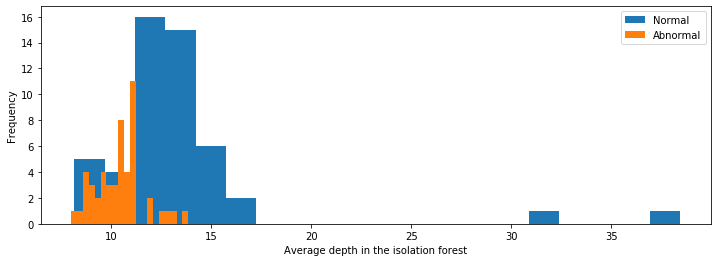

In [25]:
plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False)
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False)
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 3.2. Compute outlier scores and conclude

Use this fast method to compute harmonic numbers

In [26]:
# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

With this and the formula seen in class, you can compute outlier scores. The function below uses the *factory* design pattern to avoid computing *c(n)* every time the outlier score needs to be computed.

In [27]:
def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

[**REPORT**] Include an histogram of outlier scores of normal and abnormal elements in your report.

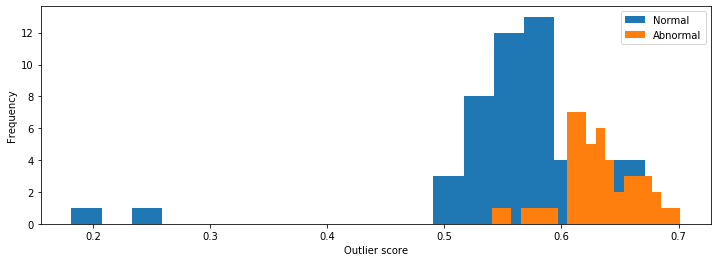

In [28]:
plt.figure(figsize=(12,4))
plt.hist(normal_scores, label='Normal', bins=20, density=False)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False)
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

[**CODE**] Write code to determine an optimal outlier score threshold based on `normal_scores` and `abnormal_scores` assuming every thyroid exam having score <= threshold will be classified as abnormal, and every thyroid exam with score > threshold will be classified as normal.

In [31]:
from scipy.stats import iqr

abnormal_outliers = []
normal_outliers = []

normal_IQR = iqr(normal_scores)
normal_Q3 = np.percentile(normal_scores, 75)
normal_threshold = normal_Q3 + 1.5*normal_IQR

abnormal_IQR = iqr(abnormal_scores)
abnormal_Q1 = np.percentile(abnormal_scores, 25)
abnormal_threshold = abnormal_Q1 - 1.5*abnormal_IQR
threshold = (normal_threshold + abnormal_threshold)/2

for element in abnormal_scores:
    if element > threshold:
        abnormal_outliers.append(element)
        
for element in normal_scores:
    if element > threshold:
        normal_outliers.append(element)

print('Threshold:', threshold)
print('Abnormal:', len(abnormal_outliers), '/', len(abnormal_scores), '=', str(100*len(abnormal_outliers)/len(abnormal_scores))+'%')
print('Normal:', len(normal_outliers), '/', len(normal_scores), '=', str(100*len(normal_outliers)/len(normal_scores))+'%')

Threshold: 0.6101498326385002
Abnormal: 41 / 50 = 82.0%
Normal: 9 / 50 = 18.0%


[**REPORT**] Describe in your report the method you used to find the best threshold, and what is the threshold you found. Indicate what is the estimated false positive rates (the probability of saying that a thyroid is abnormal when it is normal), and false negative rates (the probability of saying that a thyroid is normal when it is abnormal).

# 4. Deliver

Deliver:

* A zip file containing your notebook (.ipynb file) with all the [**CODE**] parts implemented
* A PDF report of up to 2 pages including all parts of this notebook marked with [**REPORT**].

The report should end with the following statement: **I hereby declare that, except for the code provided by the course instructors, all of our code, report, and figures were produced by myself.**